In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mesh_import import mesh
from tqdm.autonotebook import tqdm

E:\LangOn\OntoDeepLex\src\mesh\cns.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load Lexicon

In [3]:
import pickle
from itertools import chain
with open(mesh.get_data_dir() / "asbc/asbc5_words.pkl", "rb") as fin:
    aswfreq = pickle.load(fin)
# with open(mesh.get_data_dir() / "asbc/asbc5_characters.pkl", "rb") as fin:
#     ascfreq = pickle.load(fin)
# lexicon = list(chain(aswfreq.keys(), ascfreq.keys()))    
lexicon = set((x for x in aswfreq.keys() if "/" not in x))

In [4]:
len(lexicon)

217286

## Load FastText

In [ ]:
import gzip
fname = "h:/cc.zh.300.vec.gz"
fin = gzip.open(fname, 'rt', encoding='utf-8', newline='\n', errors='ignore')
n, d = map(int, fin.readline().split())
data = {}
lexicon_ft = set()
for line in tqdm(fin, total=n):
    tokens = line.rstrip().split(' ')
    if tokens[0] in lexicon:
        data[tokens[0]] = list(map(float, tokens[1:]))    
        lexicon_ft.add(tokens[0])
fin.close()

## Write FastText into HDF5

In [8]:
len(lexicon_ft)

124795

In [6]:
import h5py
import numpy as np

In [7]:
outh5_path = mesh.get_data_dir()/"ldl/semantic_vectors_fasttext.h5"
with h5py.File(outh5_path, "w") as outh:
    outh["lexicon"] = ",".join(lexicon_ft)
    vectors = outh.create_group("fasttext")
    vectors.attrs["lang"] = "zh"
    vectors.attrs["dims"] = d
    for word in tqdm(lexicon_ft):            
        vectors[word] = data[word]

## Prepare XLM-R contextualize embedding

In [12]:
import torch
from transformers import BertModel, BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertModel.from_pretrained("bert-base-multilingual-cased")

### test-round

In [13]:
inputs = tokenizer("馬肉", return_tensors="pt")

In [14]:
inputs["input_ids"]

tensor([[ 101, 8510, 6501,  102]])

In [15]:
[tokenizer.decode(x) for x in inputs["input_ids"][0].numpy().tolist()]

['[ C L S ]', '馬', '肉', '[ S E P ]']

In [16]:
import torch
with torch.no_grad():
    last, pooled, hiddens = model(inputs["input_ids"], output_hidden_states=True)

In [17]:
hiddens[0].shape

torch.Size([1, 4, 768])

In [18]:
hiddens[0][:,1:-1,:].mean(dim=1).shape

torch.Size([1, 768])

In [19]:
mat = torch.stack([x[:,1:-1,:].mean(dim=1).squeeze() for x in hiddens]).numpy()

In [20]:
mat.shape

(13, 768)

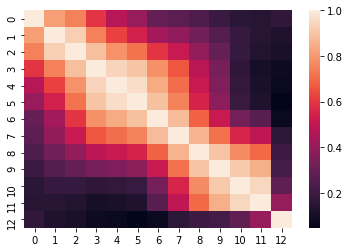

In [21]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(np.corrcoef(mat))

In [22]:
targets = list(x[:,1:-1,:] for x in hiddens)
torch.cat(targets, dim=2).mean(dim=1).squeeze().shape

torch.Size([9984])

### build concatenated all-layer BERT vectors

In [42]:
from itertools import islice
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield list(islice(iterable, ndx, min(ndx + n, l)))

In [43]:
list(batch(range(10), 3))

[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]

In [ ]:
import h5py
outh5_path = mesh.get_data_dir()/"ldl/semantic_vectors_bert.h5"
with h5py.File(outh5_path, "a") as outh:
    
    if "bert" in outh:
        del outh["bert"]
    
    vectors = outh.create_group("bert")
    vectors.attrs["model"] = "bert-base-multilingual-cased"
    vectors.attrs["dims"] = 768 * 13

    with torch.no_grad():
        for words in tqdm(batch(lexicon_ft, 16), total=len(lexicon_ft)/16):
            inputs = tokenizer(words, return_tensors="pt", padding=True)
            last, pooled, hiddens = model(**inputs, output_hidden_states=True)
            targets = [x[:,1:-1,:] for x in hiddens]
            concat_vector = torch.cat(targets, dim=2).mean(dim=1)
            for idx, word in enumerate(words):
                vectors[word] = concat_vector[idx].squeeze()            


## Play around SentencePiece

In [18]:
import re
pat = re.compile("^[\u4e00-\u9fff]+$")
segs = sorted((x for x in tokenizer.get_vocab() if pat.match(x)), key=lambda x: len(x), reverse=False)

In [20]:
segs[-50:]

['日常生活中',
 '消費者金融',
 '为客户提供',
 '新闻发布会',
 '中央社記者',
 '各种各样的',
 '前所未有的',
 '首席执行官',
 '大家都知道',
 '犯罪嫌疑人',
 '不可或缺的',
 '个工作日内',
 '中央政治局',
 '进一步加强',
 '智慧型手機',
 '高质量发展',
 '完善的售后',
 '产品和服务',
 '關鍵字搜尋',
 '拉斯维加斯',
 '微信公众号',
 '习近平主席',
 '一年一度的',
 '是怎么回事',
 '意想不到的',
 '律师事务所',
 '发展中国家',
 '股份有限公司',
 '科技有限公司',
 '习近平总书记',
 '经济社会发展',
 '值得一提的是',
 '澳门威尼斯人',
 '个国家和地区',
 '值得注意的是',
 '有限责任公司',
 '是非常重要的',
 '人民代表大会',
 '在一定程度上',
 '個人情報保護',
 '在这种情况下',
 '全面深化改革',
 '政府工作报告',
 '中华人民共和国',
 '的重要组成部分',
 '中国特色社会主义',
 '歲以下以及中國大',
 '全面建成小康社会',
 '了您的學業和身心健康請不要沉迷於',
 '习近平新时代中国特色社会主义思想']